This notebook explores different models regarding exploring solar insolation prediction

In [5]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.signal import butter, filtfilt

In [6]:
df = pd.read_csv('data/solar_data/sol_data_prepped.csv', sep=",")
# Rename the columns
df = df.rename(columns={
    'Year Month Day Hours Minutes in YYYY': 'Year',
    'MM': 'Month',
    'DD': 'Day',
    'HH24': 'Hour',
    'MI format in Local standard time': 'Minute'
})

df['datetime'] = pd.to_datetime(df.iloc[:,2:7])
datetime_col = df.pop('datetime')
df.insert(0, 'datetime', datetime_col)
df = df.set_index('datetime')
df = df.drop(['Station Number', 'sl', 'Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)
df

,Mean global irradiance (over preceding 1 minute) in W/sq m,Minimum 1 second global irradiance (over preceding 1 minute) in W/sq m,Maximum 1 second global irradiance (over preceding 1 minute) in W/sq m,Standard deviation of global irradiance (over preceding 1 minute) in W/sq m,Uncertainty in mean global irradiance (over preceding 1 minute) in W/sq m,Mean direct irradiance (over preceding 1 minute) in W/sq m,Minimum 1 second direct irradiance (over preceding 1 minute) in W/sq m,Maximum 1 second direct irradiance (over preceding 1 minute) in W/sq m,Standard deviation of direct irradiance (over preceding 1 minute) in W/sq m,Uncertainty in mean direct irradiance (over preceding 1 minute) in W/sq m,...,Uncertainty in mean terrestrial irradiance (over preceding 1 minute) in W/sq m,Mean direct horizontal irradiance (over preceding 1 minute) in W/sq m,Minimum 1 second direct horizontal irradiance (over preceding 1 minute) in W/sq m,Maximum 1 second direct horizontal irradiance (over preceding 1 minute) in W/sq m,Standard deviation of direct horizontal irradiance (over preceding 1 minute) in W/sq m,Uncertainty in mean direct horizontal irradiance (over preceding 1 minute) in W/sq m,Sunshine-seconds-96 (duration of DNI exceeding 96 W/sq m over preceding 1 minute) in seconds,Sunshine-seconds-120 (duration of DNI exceeding 120 W/sq m over preceding 1 minute) in seconds,Sunshine-seconds-144 (duration of DNI exceeding 144 W/sq m over preceding 1 minute) in seconds,Zenith distance in degrees
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
2012-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
2012-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
2012-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
2012-01-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-31 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
2012-01-31 23:56:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0
2012-01-31 23:57:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0


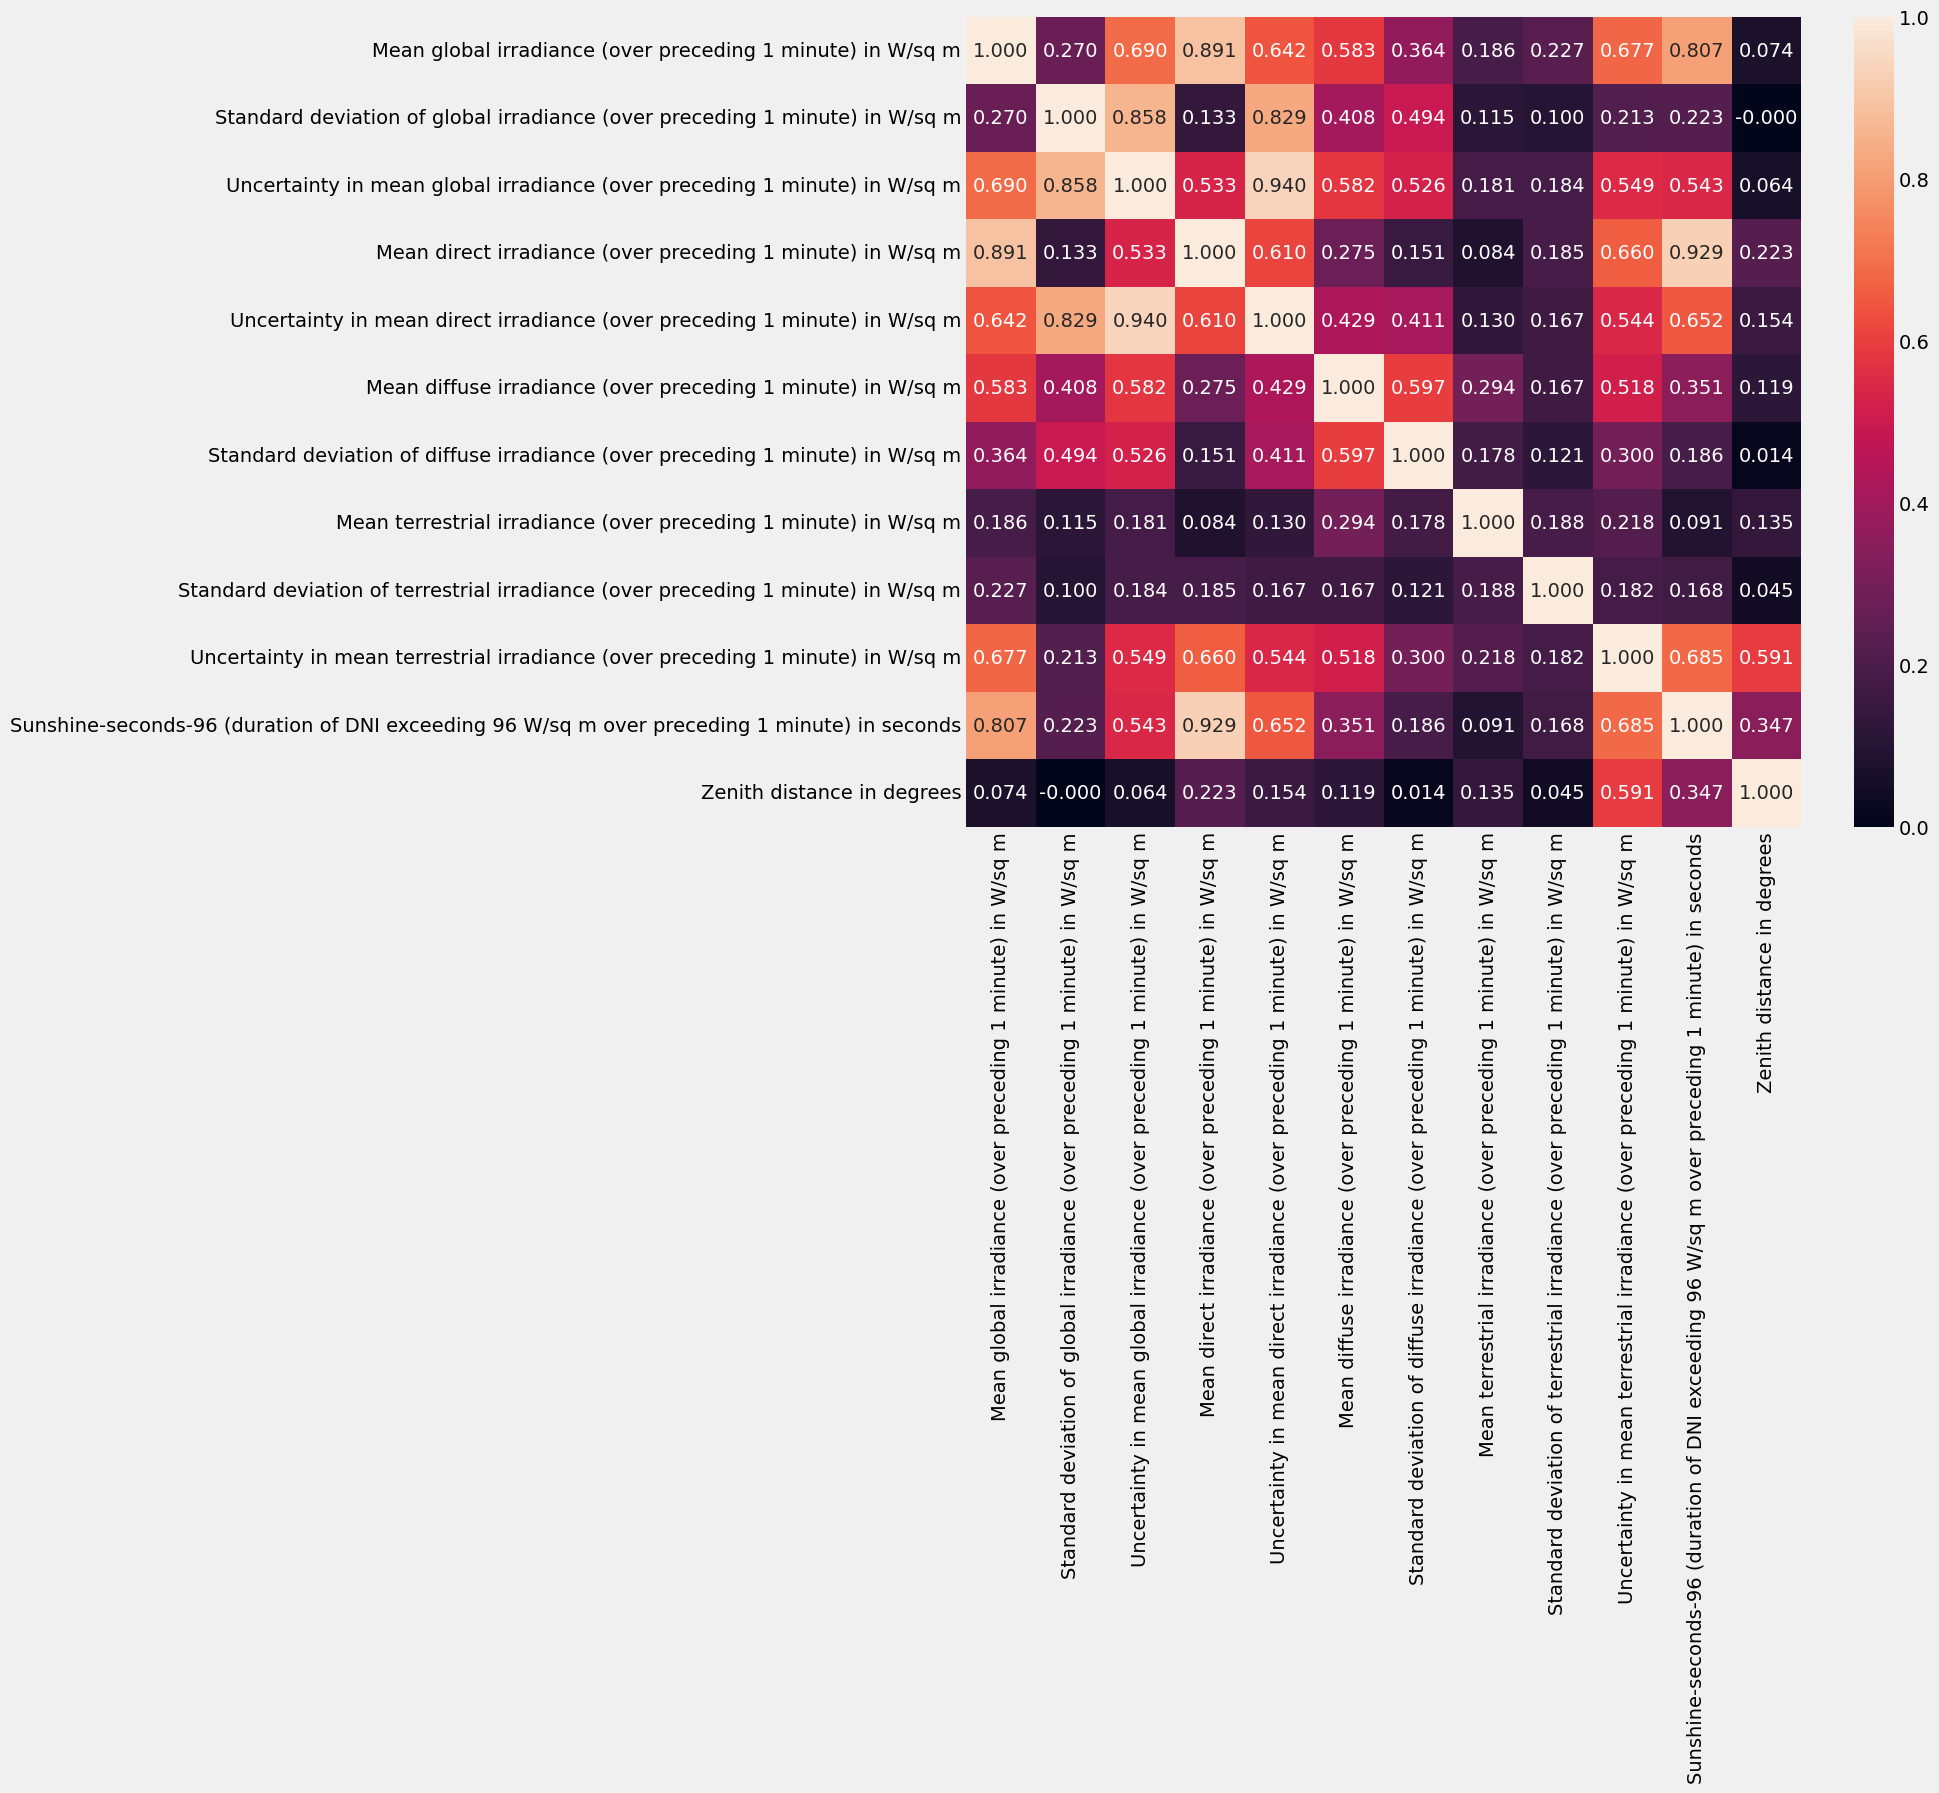

In [7]:
# Create correlation matrix
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)
corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrMatrix, annot= True, ax=ax, fmt='.3f')
plt.show()

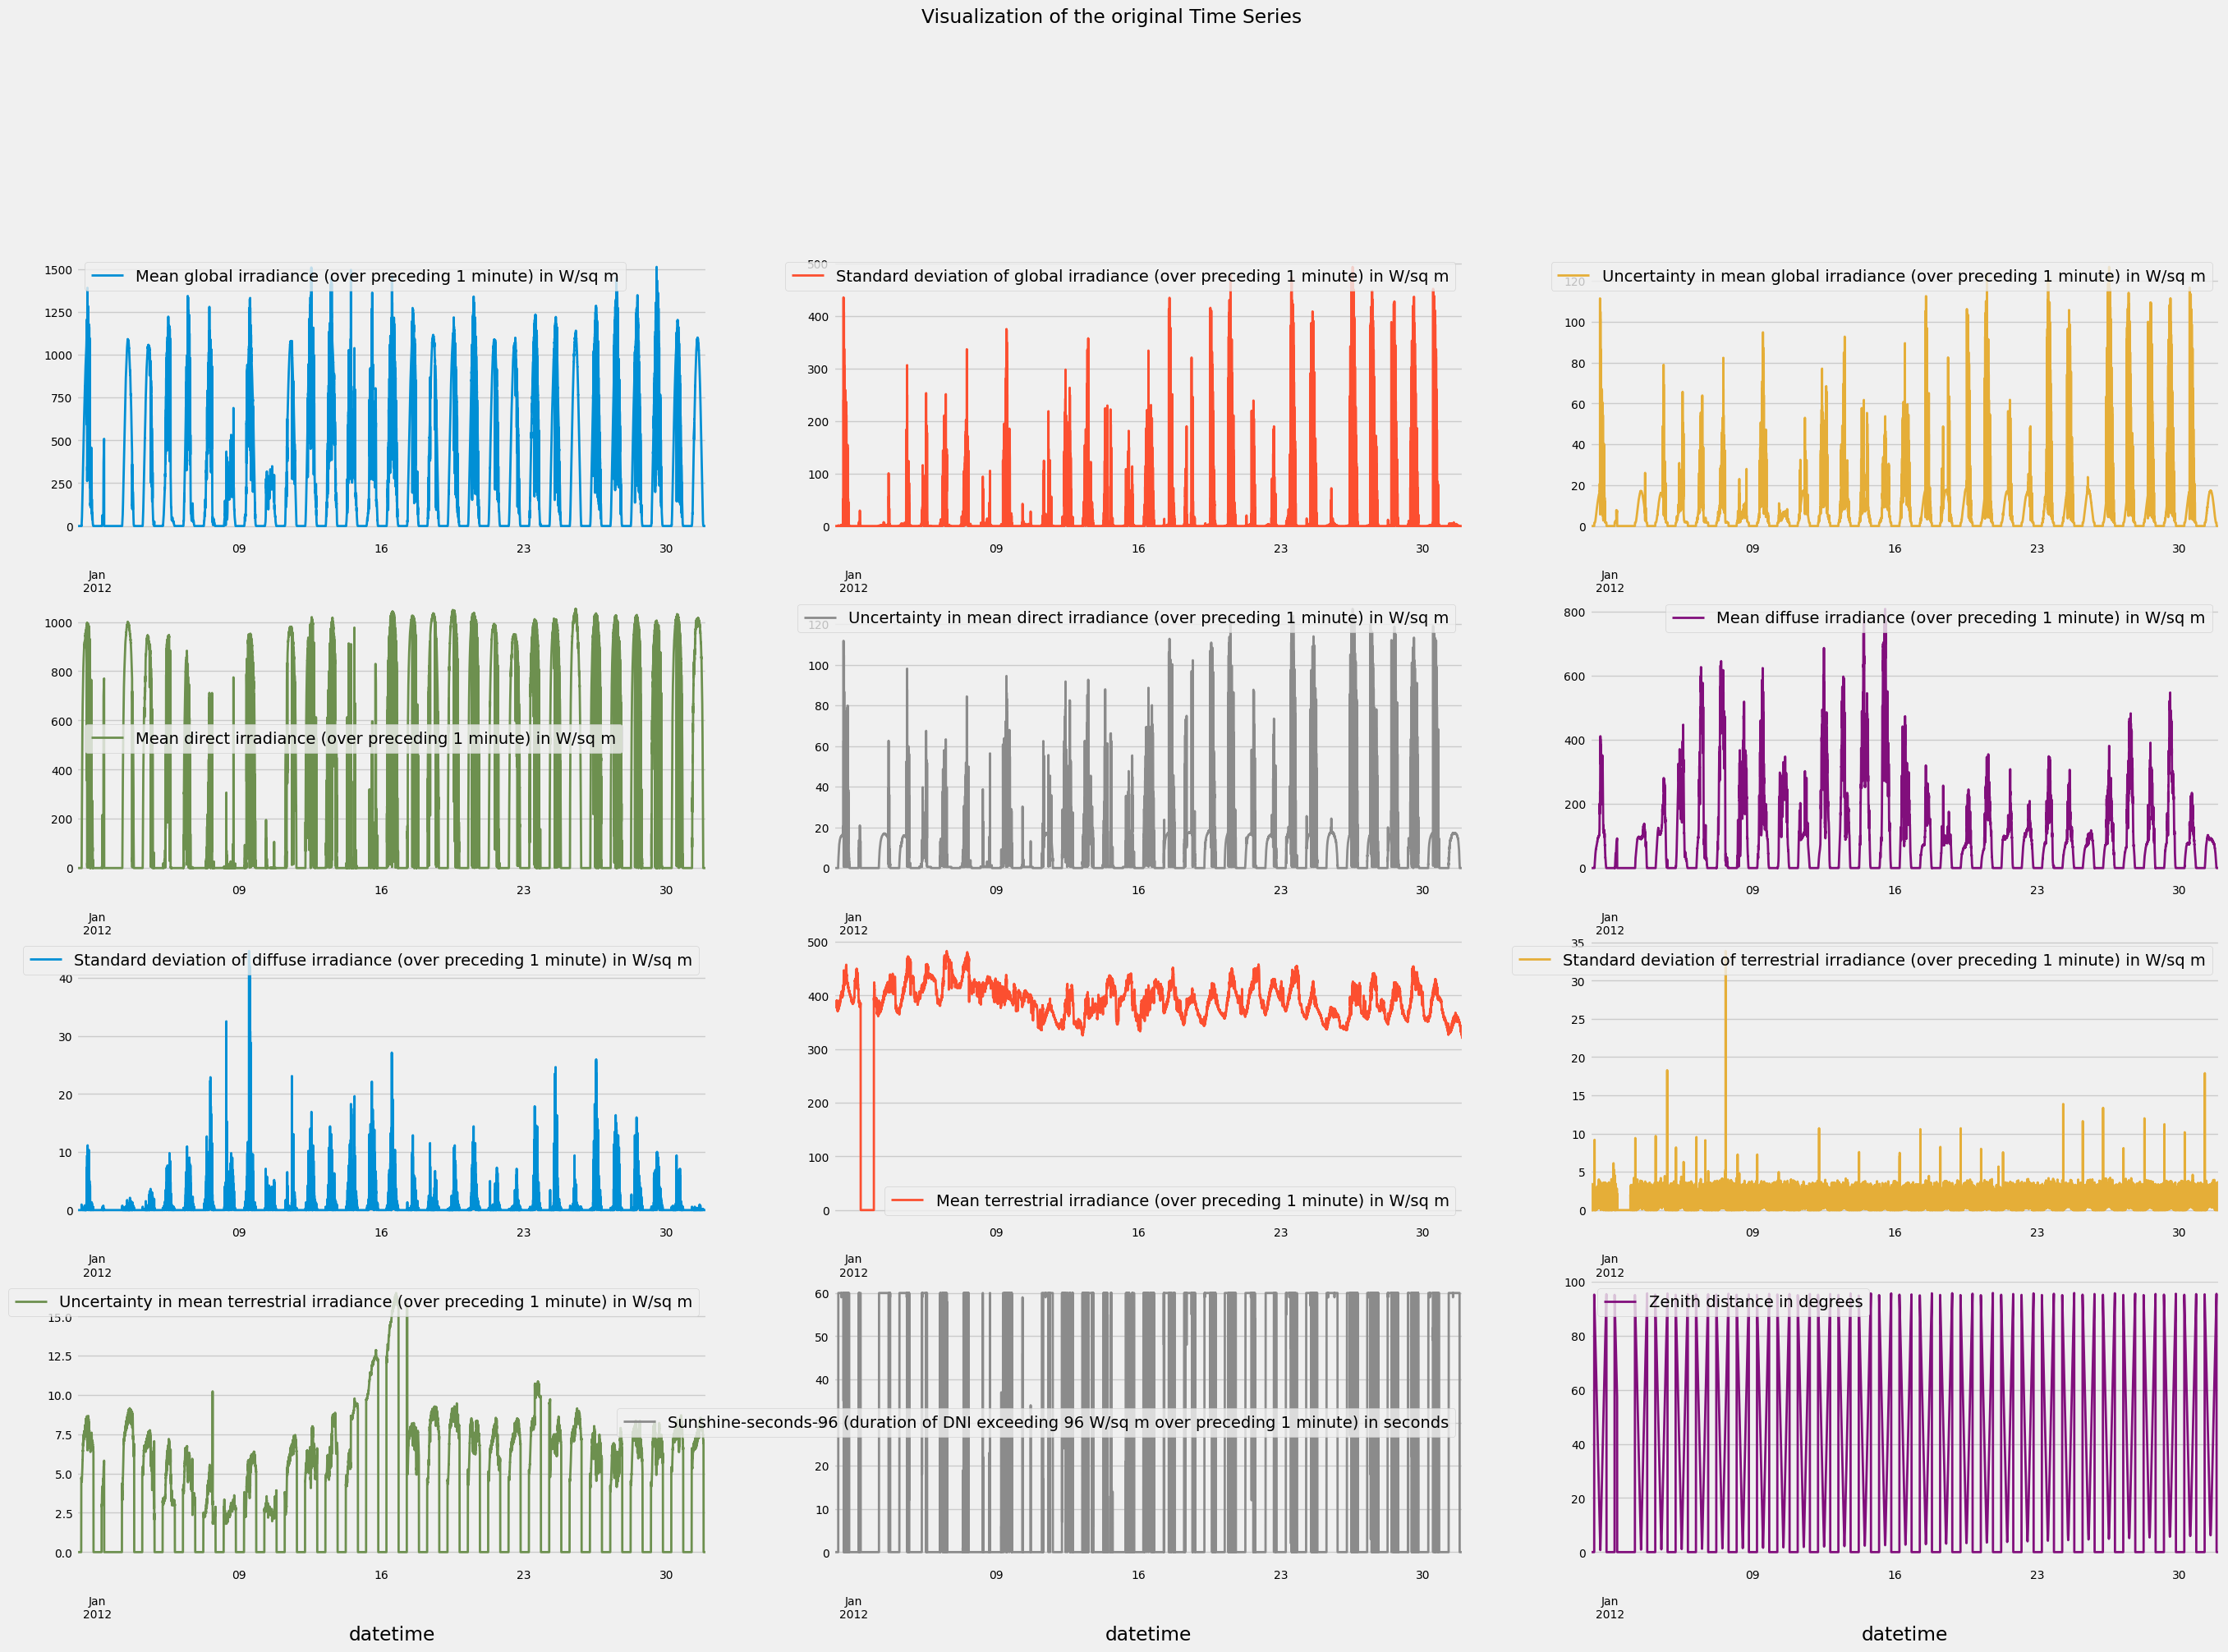

In [8]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(30,30),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

lets check for high freq noise

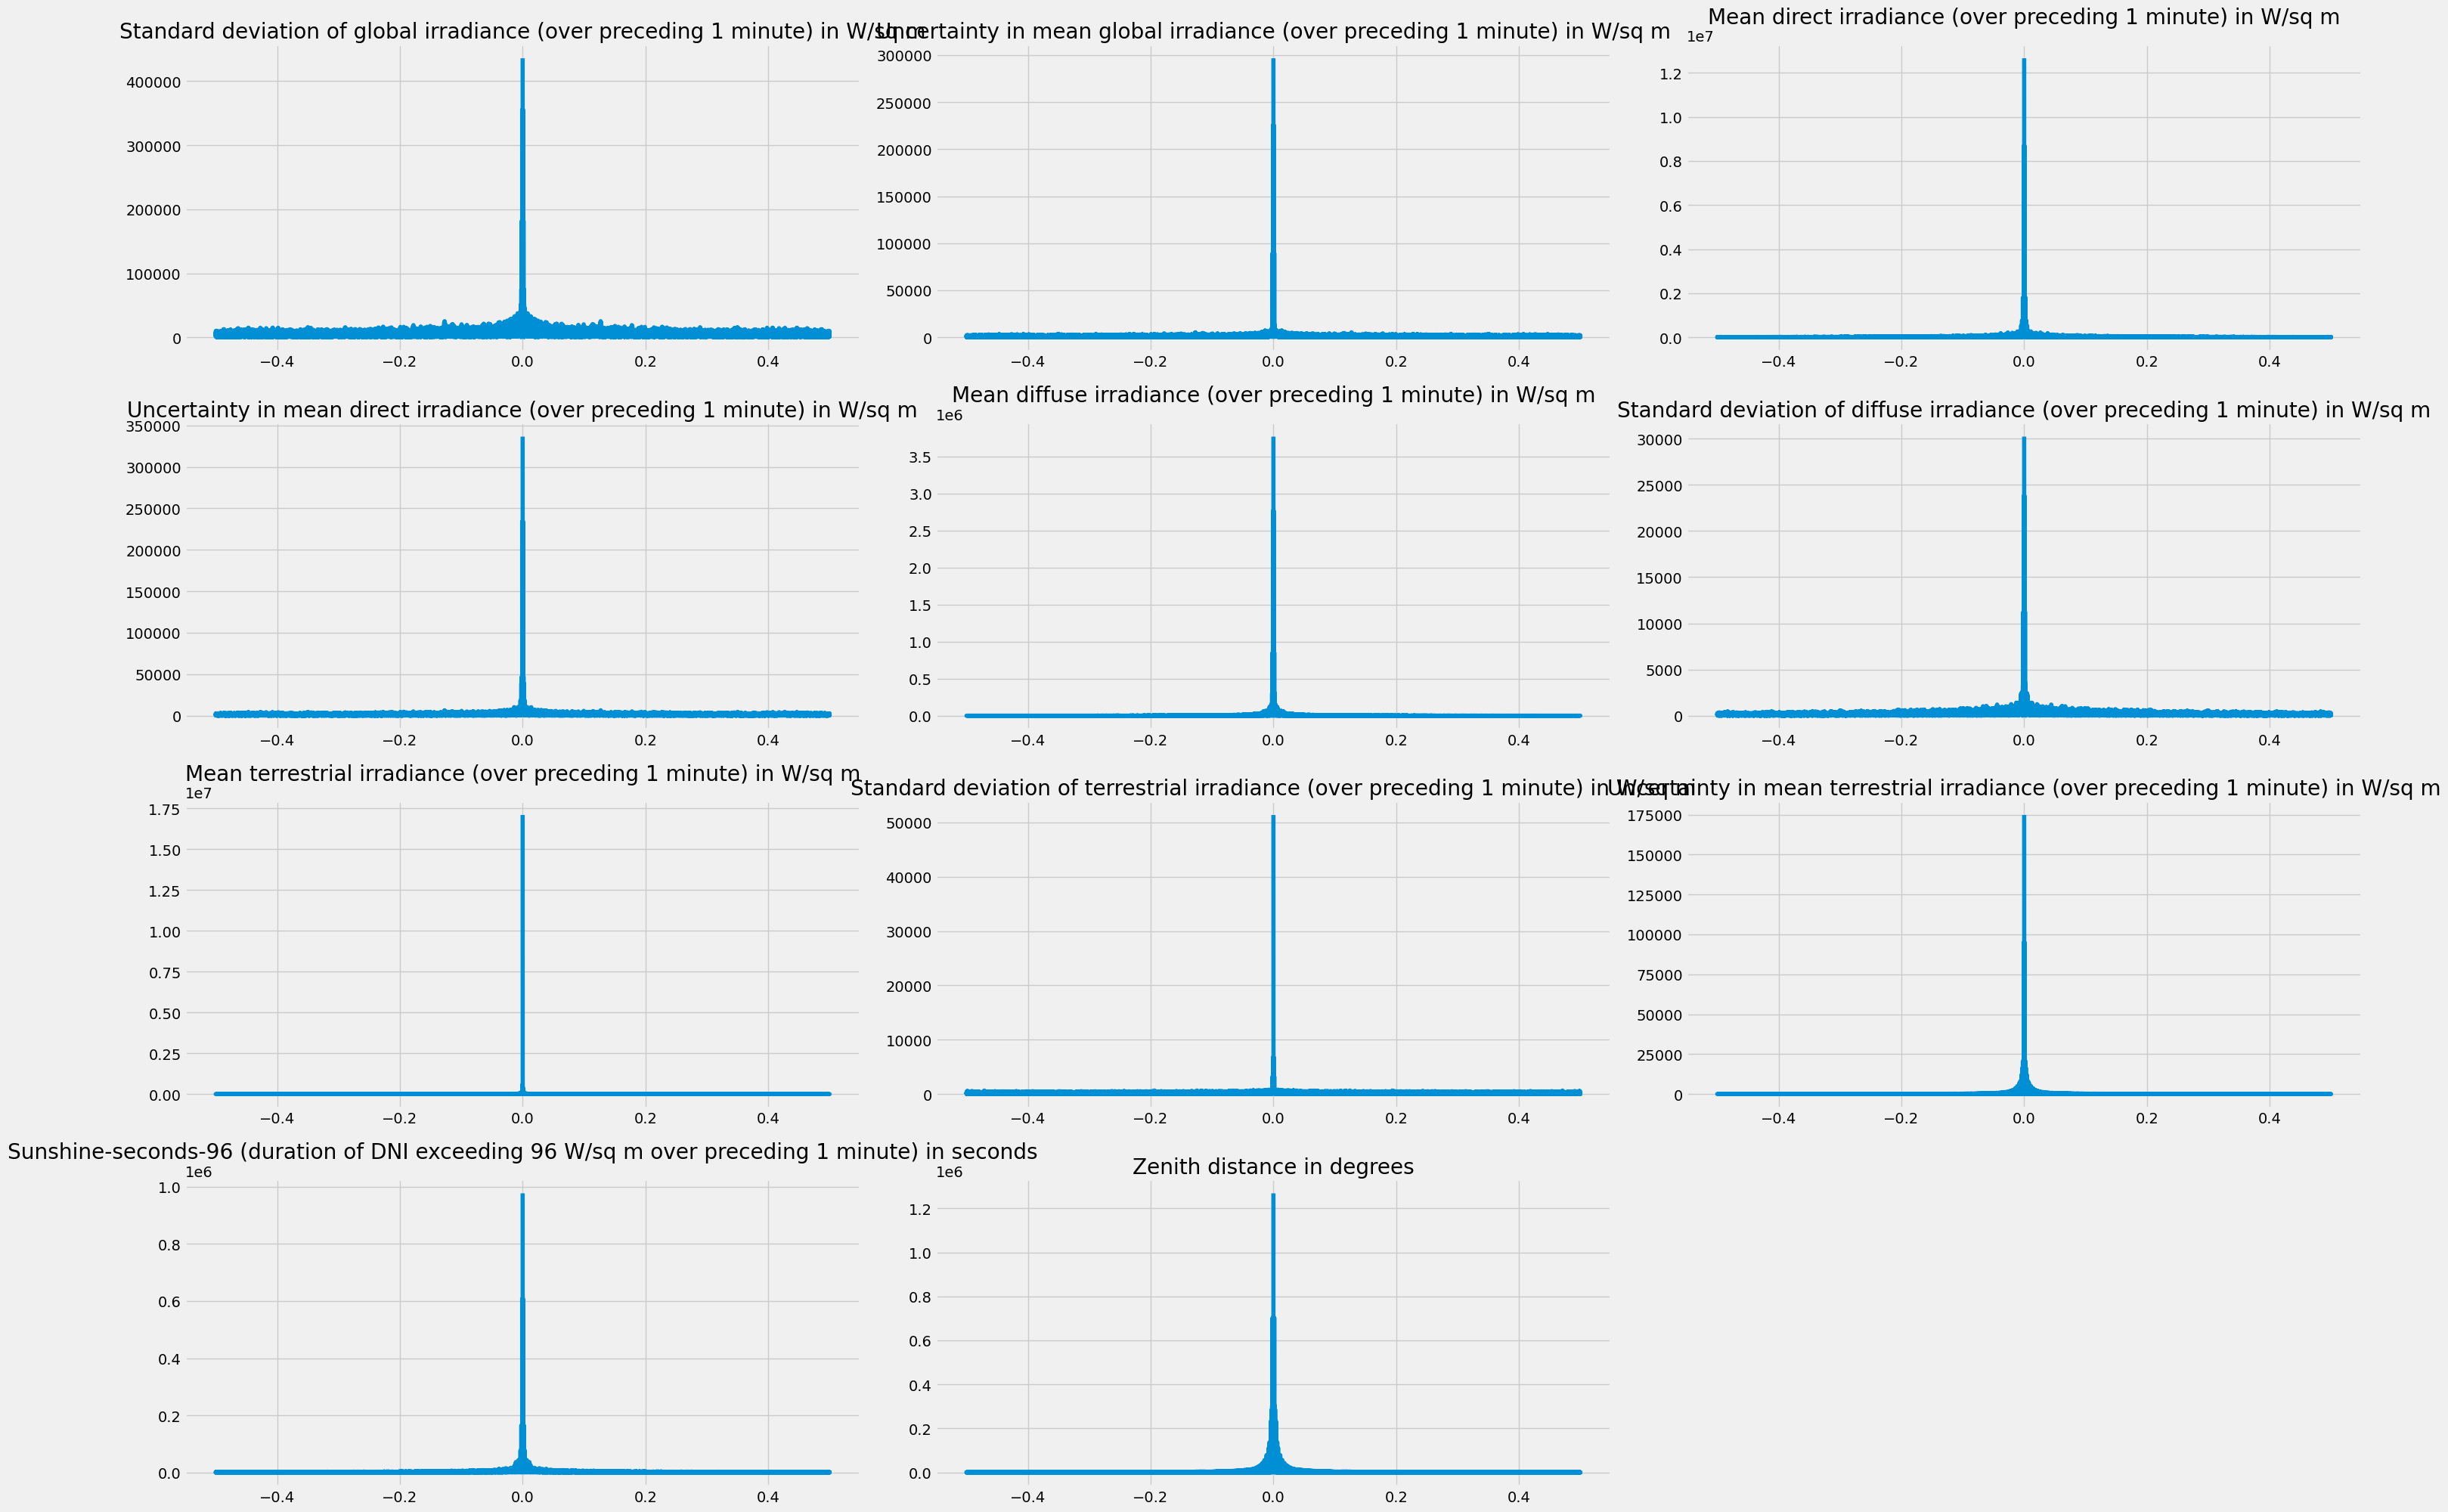

In [9]:

# apply Fourier transform to each column
fft_data = np.fft.fft(df.iloc[:, 1:], axis=0)

# calculate the frequency axis
freq = np.fft.fftfreq(df.shape[0], d=1)

# plot the frequency spectrum
plt.figure(figsize=(30, 30))
for i, col in enumerate(df.columns[1:]):
    plt.subplot(6, 3, i+1)
    plt.plot(freq, np.abs(fft_data[:, i]))
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
# 80-20 split
training_size = int ( 0.8 * df.shape[0])  
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:]

In [ ]:
plt.plot(train_data.index, train_data[['air_temp']], label = 'train data')
plt.plot(val_data.index, val_data[['air_temp']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()